<a href="https://colab.research.google.com/github/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation/blob/main/Liver_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Git if not already installed
!apt-get install git -qq

# Configure Git with your info
!git config --global user.email "safinazmo7amed@gmail.com.com"
!git config --global user.name "Safinaz-Muhammad"

# Clone your GitHub repo (only once)
!git clone https://github.com/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation

Cloning into 'Task-1--Medical-Images-Segmentation'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (501/501), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 501 (delta 14), reused 501 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (501/501), 23.79 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
# ========================
# 1. Kaggle API Setup
# ========================
from google.colab import files
files.upload()  # Upload your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ========================
# 2. Download liver dataset
# ========================
!mkdir -p ./datasets/liver
!kaggle datasets download -d louisgv/couinaud-liver-segmentation -p ./datasets/liver --unzip



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/louisgv/couinaud-liver-segmentation
License(s): other
100% 3.38G/3.39G [01:13<00:00, 66.4MB/s]
100% 3.39G/3.39G [01:14<00:00, 49.1MB/s]


In [ ]:
# ========================
# 3. Imports
# ========================
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# ========================
# 4. Preprocessing
# ========================
def load_and_preprocess_image(image_path, target_size=(128,128)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    return np.array(img) / 255.0

def load_and_preprocess_mask(mask_path, target_size=(128,128)):
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(target_size, Image.NEAREST)
    return np.array(mask).astype(np.uint8)  # keep original class labels


In [ ]:
# ========================
# 5. Load liver dataset
# ========================
import nibabel as nib # Import nibabel
import os
import numpy as np
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(128,128)):
    try:
        # Load .nii files using nibabel
        img_nii = nib.load(image_path)
        img = img_nii.get_fdata()

        # Assuming the image is 3D (height, width, depth), take a slice or process as needed
        # For now, let's take the middle slice as an example
        if img.ndim == 3:
            img = img[:, :, img.shape[-1] // 2]

        # Normalize and resize
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0 # Scale to 0-255
        img = Image.fromarray(img.astype(np.uint8)).convert("RGB")
        img = img.resize(target_size)
        return np.array(img) / 255.0
    except OSError as e:
        print(f"Error loading image file {image_path}: {e}. Skipping this file.")
        return None


def load_and_preprocess_mask(mask_path, target_size=(128,128)):
    try:
        # Load .nii files using nibabel (assuming masks are also .nii)
        mask_nii = nib.load(mask_path)
        mask = mask_nii.get_fdata()

        # Assuming the mask is 3D, take the middle slice
        if mask.ndim == 3:
             mask = mask[:, :, mask.shape[-1] // 2]

        # Ensure mask values are 0 or 1 for binary segmentation
        mask = (mask > 0).astype(np.uint8)

        # Resize the mask using nearest neighbor interpolation to preserve labels
        mask = Image.fromarray(mask.astype(np.uint8)).resize(target_size, Image.NEAREST)
        return np.array(mask)
    except OSError as e:
        print(f"Error loading mask file {mask_path}: {e}. Skipping this file.")
        return None


def load_liver_dataset(base_path="./datasets/liver"):
    img_dir = os.path.join(base_path, "images") # Images are here
    mask_dir = os.path.join(base_path, "annotation", "liver") # Masks are here

    images, masks = [], []

    # Get list of image files
    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith((".nii"))])

    # Iterate through image files and find corresponding mask files
    for img_filename in image_files:
        img_path = os.path.join(img_dir, img_filename)
        mask_filename = img_filename # Assuming mask filename is the same as image filename
        mask_path = os.path.join(mask_dir, mask_filename)

        if os.path.exists(mask_path):
            img = load_and_preprocess_image(img_path)
            mask = load_and_preprocess_mask(mask_path)

            if img is not None and mask is not None: # Only append if both loading was successful
                images.append(img)
                masks.append(mask)
        else:
            print(f"No corresponding mask found for image: {img_filename}. Skipping.")


    images = np.array(images)
    masks = np.expand_dims(np.array(masks), -1)
    print(f"Liver dataset loaded: {images.shape[0]} samples")
    return images, masks

# Load dataset
X, y = load_liver_dataset()

# Calculate num_classes after y is loaded
num_classes = int(np.max(y)) + 1

Liver dataset loaded: 193 samples


In [ ]:
# ========================
# 6. Get number of classes
# ========================
num_classes = int(np.max(y)) + 1
print("Number of classes:", num_classes)

# ========================
# 7. Train/Validation Split
# ========================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)




Number of classes: 2


In [ ]:
import os

# List files in the image directory
image_dir = "./datasets/liver/images"
if os.path.exists(image_dir):
    print(f"Files in {image_dir}:")
    for item in os.listdir(image_dir):
        print(item)
else:
    print(f"Directory not found: {image_dir}")

print("-" * 30)

# List files in the annotation/liver mask directory
mask_dir = "./datasets/liver/annotation/liver"
if os.path.exists(mask_dir):
    print(f"Files in {mask_dir}:")
    for item in os.listdir(mask_dir):
        print(item)
else:
    print(f"Directory not found: {mask_dir}")

Files in ./datasets/liver/images:
hepaticvessel_087.nii
hepaticvessel_090.nii
hepaticvessel_237.nii
hepaticvessel_125.nii
hepaticvessel_144.nii
hepaticvessel_309.nii
hepaticvessel_363.nii
hepaticvessel_071.nii
hepaticvessel_062.nii
hepaticvessel_369.nii
hepaticvessel_052.nii
hepaticvessel_183.nii
hepaticvessel_381.nii
hepaticvessel_082.nii
hepaticvessel_051.nii
hepaticvessel_371.nii
hepaticvessel_111.nii
hepaticvessel_086.nii
hepaticvessel_299.nii
hepaticvessel_223.nii
hepaticvessel_089.nii
hepaticvessel_333.nii
hepaticvessel_341.nii
hepaticvessel_067.nii
hepaticvessel_207.nii
hepaticvessel_425.nii
hepaticvessel_108.nii
hepaticvessel_227.nii
hepaticvessel_305.nii
hepaticvessel_415.nii
hepaticvessel_055.nii
hepaticvessel_009.nii
hepaticvessel_301.nii
hepaticvessel_138.nii
hepaticvessel_421.nii
hepaticvessel_133.nii
hepaticvessel_105.nii
hepaticvessel_179.nii
hepaticvessel_279.nii
hepaticvessel_275.nii
hepaticvessel_139.nii
hepaticvessel_447.nii
hepaticvessel_153.nii
hepaticvessel_003.ni

In [ ]:
import os

# List files in the mask directory
mask_dir = "./datasets/liver/dataset/masks"
if os.path.exists(mask_dir):
    print(f"Files in {mask_dir}:")
    for item in os.listdir(mask_dir):
        print(item)
else:
    print(f"Directory not found: {mask_dir}")

Directory not found: ./datasets/liver/dataset/masks


In [ ]:
import os

# List files in the mask directory
mask_dir = "./datasets/liver/masks"
if os.path.exists(mask_dir):
    print(f"Files in {mask_dir}:")
    for item in os.listdir(mask_dir):
        print(item)
else:
    print(f"Directory not found: {mask_dir}")

Directory not found: ./datasets/liver/masks


In [ ]:
import os

# List files in the annotation directory and its subdirectories
annotation_dir = "./datasets/liver/annotation"
if os.path.exists(annotation_dir):
    print(f"Contents of {annotation_dir}:")
    for item in os.listdir(annotation_dir):
        item_path = os.path.join(annotation_dir, item)
        if os.path.isdir(item_path):
            print(f"  Directory: {item}")
            # List contents of subdirectories
            print(f"    Contents of {item}:")
            for sub_item in os.listdir(item_path):
                print(f"      - {sub_item}")
        else:
            print(f"  File: {item}")
else:
    print(f"Directory not found: {annotation_dir}")

Contents of ./datasets/liver/annotation:
  Directory: liver
    Contents of liver:
      - hepaticvessel_087.nii
      - hepaticvessel_172.nii
      - hepaticvessel_199.nii
      - hepaticvessel_120.nii
      - hepaticvessel_419.nii
      - hepaticvessel_090.nii
      - hepaticvessel_326.nii
      - hepaticvessel_368.nii
      - hepaticvessel_060.nii
      - hepaticvessel_237.nii
      - hepaticvessel_125.nii
      - hepaticvessel_354.nii
      - hepaticvessel_144.nii
      - hepaticvessel_210.nii
      - hepaticvessel_248.nii
      - hepaticvessel_309.nii
      - hepaticvessel_451.nii
      - hepaticvessel_208.nii
      - hepaticvessel_363.nii
      - hepaticvessel_079.nii
      - hepaticvessel_440.nii
      - hepaticvessel_228.nii
      - hepaticvessel_406.nii
      - hepaticvessel_290.nii
      - hepaticvessel_071.nii
      - hepaticvessel_062.nii
      - hepaticvessel_369.nii
      - hepaticvessel_052.nii
      - hepaticvessel_252.nii
      - hepaticvessel_183.nii
      - hepaticve

In [ ]:
import os

# List files in the ./datasets/liver/ directory and its subdirectories
dataset_dir = "./datasets/liver/"
if os.path.exists(dataset_dir):
    print(f"Contents of {dataset_dir}:")
    for item in os.listdir(dataset_dir):
        item_path = os.path.join(dataset_dir, item)
        if os.path.isdir(item_path):
            print(f"  Directory: {item}")
            # List contents of subdirectories
            print(f"    Contents of {item}:")
            for sub_item in os.listdir(item_path):
                print(f"      - {sub_item}")
        else:
            print(f"  File: {item}")
else:
    print(f"Directory not found: {dataset_dir}")

Contents of ./datasets/liver/:
  Directory: annotation
    Contents of annotation:
      - liver
      - couinaud
  Directory: images
    Contents of images:
      - hepaticvessel_087.nii
      - hepaticvessel_090.nii
      - hepaticvessel_237.nii
      - hepaticvessel_125.nii
      - hepaticvessel_144.nii
      - hepaticvessel_309.nii
      - hepaticvessel_363.nii
      - hepaticvessel_071.nii
      - hepaticvessel_062.nii
      - hepaticvessel_369.nii
      - hepaticvessel_052.nii
      - hepaticvessel_183.nii
      - hepaticvessel_381.nii
      - hepaticvessel_082.nii
      - hepaticvessel_051.nii
      - hepaticvessel_371.nii
      - hepaticvessel_111.nii
      - hepaticvessel_086.nii
      - hepaticvessel_299.nii
      - hepaticvessel_223.nii
      - hepaticvessel_089.nii
      - hepaticvessel_333.nii
      - hepaticvessel_341.nii
      - hepaticvessel_067.nii
      - hepaticvessel_207.nii
      - hepaticvessel_425.nii
      - hepaticvessel_108.nii
      - hepaticvessel_227.nii
  

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - accuracy: 0.9023 - dice_coefficient: 0.6565 - iou_score: 0.5066 - loss: 0.5065 - val_accuracy: 0.9210 - val_dice_coefficient: 0.8927 - val_iou_score: 0.8066 - val_loss: 0.1745
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.9254 - dice_coefficient: 0.9015 - iou_score: 0.8211 - loss: 0.1604 - val_accuracy: 0.9210 - val_dice_coefficient: 0.9017 - val_iou_score: 0.8212 - val_loss: 0.1646
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 403ms/step - accuracy: 0.9286 - dice_coefficient: 0.9042 - iou_score: 0.8254 - loss: 0.1497 - val_accuracy: 0.9210 - val_dice_coefficient: 0.8949 - val_iou_score: 0.8101 - val_loss: 0.1599
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.9323 - dice_coefficient: 0.9098 - iou_score: 0.8348 - loss: 0.1382 - val_accuracy: 0.9234 - val_dice_coefficient: 0.9139 - val_iou_score: 0.8417 - val_loss: 0.1422
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.9339 - di

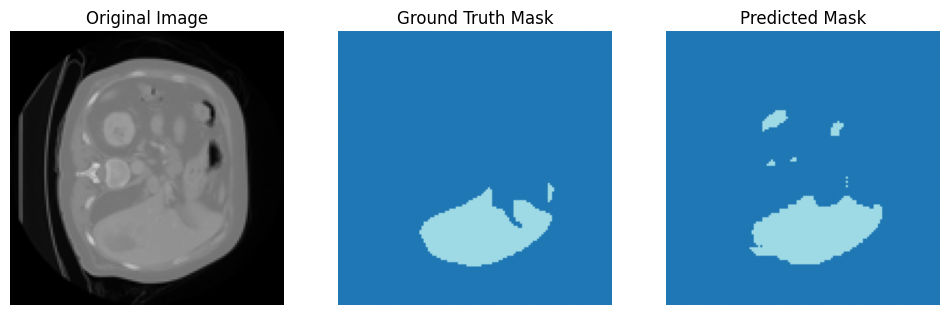

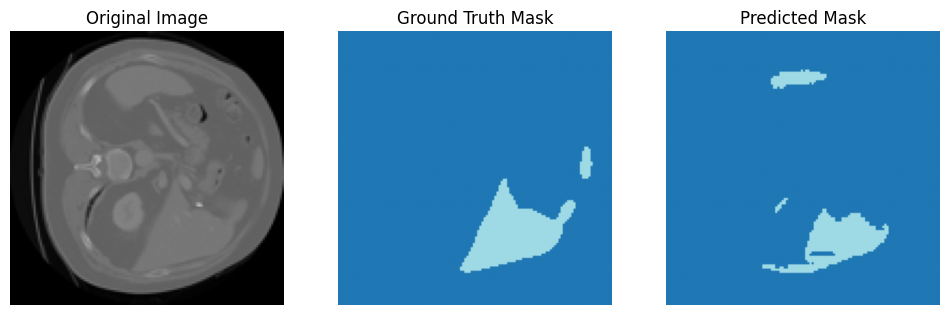

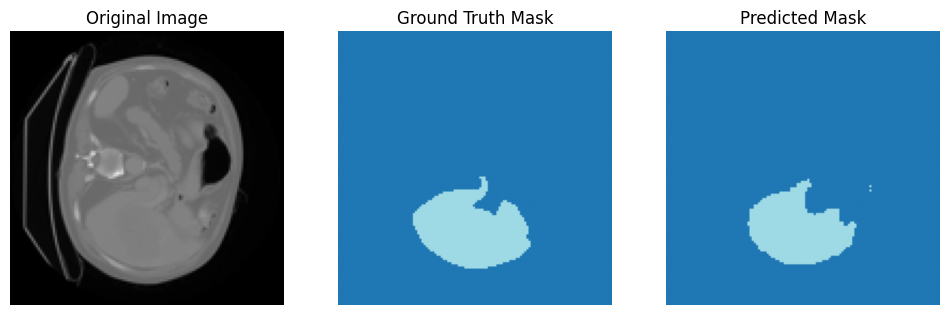

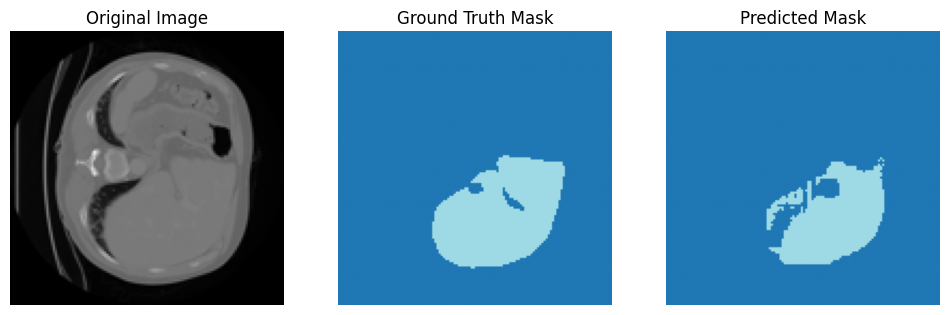

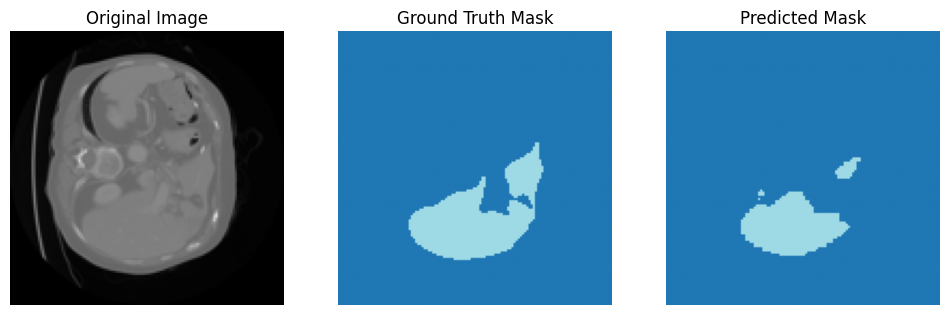

In [ ]:
# ========================
# 8. Metrics & compile
# ========================
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, -1), tf.int32), depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, -1), tf.int32), depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", dice_coefficient, iou_score]
    )
    return model

# ========================
# 9. U-Net Model
# ========================
def simple_unet(input_size=(128,128,3), num_classes=num_classes):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    # Decoder
    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(b)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    u1 = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u1 = layers.concatenate([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c4)
    return models.Model(inputs, outputs)

# ========================
# 10. Train Model
# ========================
model = compile_model(simple_unet(input_size=X_train.shape[1:], num_classes=num_classes))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=4)

# ========================
# 11. Visualize Predictions
# ========================
def visualize_liver_predictions(model, X, y, num_samples=5):
    preds = model.predict(X[:num_samples])
    preds_classes = np.argmax(preds, axis=-1)

    for i in range(num_samples):
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(y[i].squeeze(), cmap="tab20")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(preds_classes[i], cmap="tab20")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Visualize results
visualize_liver_predictions(model, X_val, y_val, num_samples=5)

In [ ]:
import os

# List files in the dataset directory to inspect naming conventions
dataset_dir = "./datasets/liver/dataset"
if os.path.exists(dataset_dir):
    print(f"Files in {dataset_dir}:")
    for item in os.listdir(dataset_dir):
        print(item)
else:
    print(f"Directory not found: {dataset_dir}")

Directory not found: ./datasets/liver/dataset


In [ ]:
import os

# List files in the ./datasets/liver/ directory
dataset_dir = "./datasets/liver/"
if os.path.exists(dataset_dir):
    print(f"Contents of {dataset_dir}:")
    for item in os.listdir(dataset_dir):
        item_path = os.path.join(dataset_dir, item)
        if os.path.isdir(item_path):
            print(f"  Directory: {item}")
            # Optionally, list contents of subdirectories if needed
            # for sub_item in os.listdir(item_path):
            #     print(f"    - {sub_item}")
        else:
            print(f"  File: {item}")
else:
    print(f"Directory not found: {dataset_dir}")

Contents of ./datasets/liver/:
  Directory: annotation
  Directory: images


In [ ]:
import os

# List files in the image directory
image_dir = "./datasets/liver/images"
if os.path.exists(image_dir):
    print(f"Files in {image_dir}:")
    for item in os.listdir(image_dir):
        print(item)
else:
    print(f"Directory not found: {image_dir}")

print("-" * 30)

# List files in the mask directory
mask_dir = "./datasets/liver/masks"
if os.path.exists(mask_dir):
    print(f"Files in {mask_dir}:")
    for item in os.listdir(mask_dir):
        print(item)
else:
    print(f"Directory not found: {mask_dir}")

Files in ./datasets/liver/images:
hepaticvessel_087.nii
hepaticvessel_090.nii
hepaticvessel_237.nii
hepaticvessel_125.nii
hepaticvessel_144.nii
hepaticvessel_309.nii
hepaticvessel_363.nii
hepaticvessel_071.nii
hepaticvessel_062.nii
hepaticvessel_369.nii
hepaticvessel_052.nii
hepaticvessel_183.nii
hepaticvessel_381.nii
hepaticvessel_082.nii
hepaticvessel_051.nii
hepaticvessel_371.nii
hepaticvessel_111.nii
hepaticvessel_086.nii
hepaticvessel_299.nii
hepaticvessel_223.nii
hepaticvessel_089.nii
hepaticvessel_333.nii
hepaticvessel_341.nii
hepaticvessel_067.nii
hepaticvessel_207.nii
hepaticvessel_425.nii
hepaticvessel_108.nii
hepaticvessel_227.nii
hepaticvessel_305.nii
hepaticvessel_415.nii
hepaticvessel_055.nii
hepaticvessel_009.nii
hepaticvessel_301.nii
hepaticvessel_138.nii
hepaticvessel_421.nii
hepaticvessel_133.nii
hepaticvessel_105.nii
hepaticvessel_179.nii
hepaticvessel_279.nii
hepaticvessel_275.nii
hepaticvessel_139.nii
hepaticvessel_447.nii
hepaticvessel_153.nii
hepaticvessel_003.ni

In [ ]:
# ========================
# 2️⃣ SegNet Model
# ========================
def simple_segnet(input_size=(128,128,3), num_classes=2):  # 2 for liver mask (BG + liver)
    inputs = layers.Input(input_size)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x) # Keep softmax for now
    return models.Model(inputs, outputs)

# Compile model
segnet_liver = simple_segnet(input_size=X_train.shape[1:], num_classes=2) # Hardcode num_classes to 2
segnet_liver.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ========================
# One-hot encode masks
# ========================
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)


# ========================
# 3️⃣ Train SegNet
# ========================
history = segnet_liver.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=5, batch_size=4
)

# Visualize results - using the original visualize_liver_predictions function which uses matplotlib.pyplot
# Ensure matplotlib.pyplot is imported and available as plt

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8944 - loss: 0.4631 - val_accuracy: 0.9210 - val_loss: 0.1738
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 856ms/step - accuracy: 0.9262 - loss: 0.1610 - val_accuracy: 0.9210 - val_loss: 0.1668
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 950ms/step - accuracy: 0.9327 - loss: 0.1391 - val_accuracy: 0.9210 - val_loss: 0.1696
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 914ms/step - accuracy: 0.9260 - loss: 0.1366 - val_accuracy: 0.9210 - val_loss: 0.1470
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 899ms/step - accuracy: 0.9273 - loss: 0.1341 - val_accuracy: 0.9210 - val_loss: 0.1343


In [ ]:

# ========================
# 4️⃣ Predict
# ========================
preds = segnet_liver.predict(X_val)
preds_classes = np.argmax(preds, axis=-1)  # shape: (N,H,W)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step


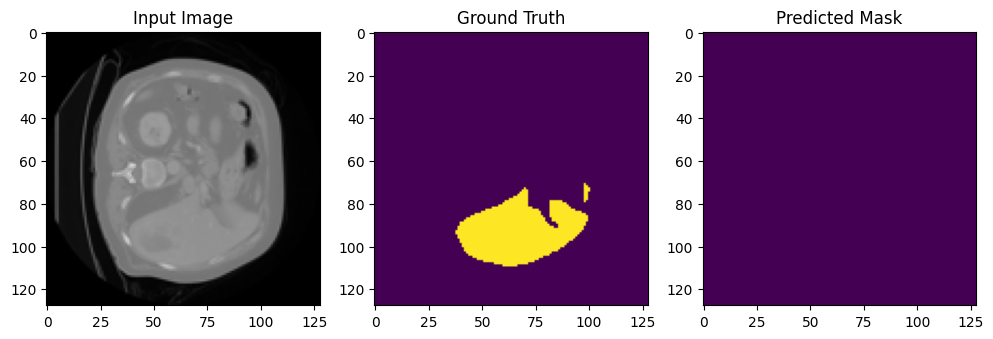

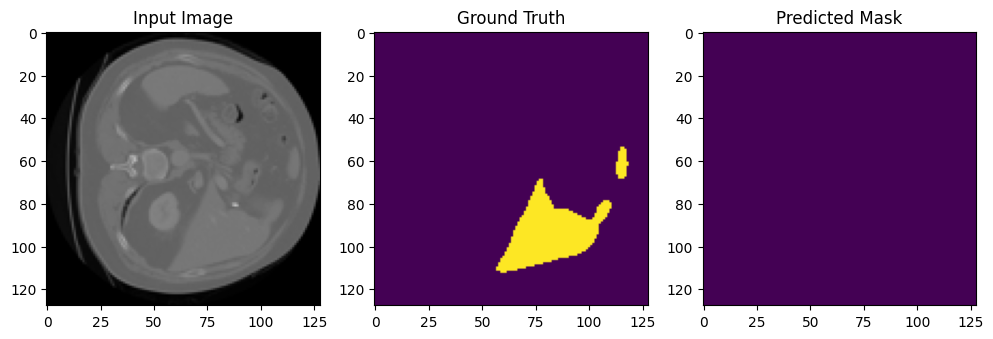

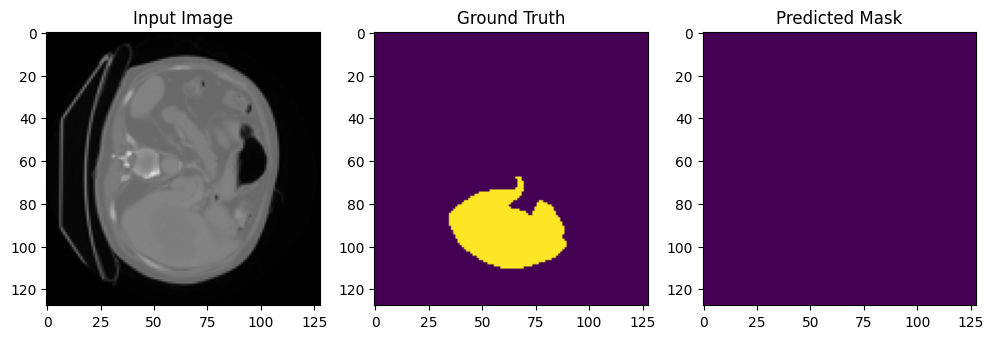

In [ ]:
import matplotlib.pyplot as plt

def visualize_liver_predictions(X, y_true, y_pred_classes, num=3):
    """
    X: input images (N,H,W,C)
    y_true: ground truth masks (N,H,W)
    y_pred_classes: predicted masks (N,H,W)
    """
    for i in range(num):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title("Input Image")

        plt.subplot(1,3,2)
        plt.imshow(y_true[i].squeeze())
        plt.title("Ground Truth")

        plt.subplot(1,3,3)
        plt.imshow(y_pred_classes[i])
        plt.title("Predicted Mask")
        plt.show()

# Example: visualize first 3 liver slices
visualize_liver_predictions(X_val, y_val, preds_classes, num=3)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 2)    │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,154 (1.13 MB)

 Trainable params: 297,154 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 886ms/step - accuracy: 0.4993 - dice_coefficient: 0.4104 - iou_score: 0.2701 - loss: 0.6933 - val_accuracy: 0.5000 - val_dice_coefficient: 0.2945 - val_iou_score: 0.1727 - val_loss: 0.6932
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step - accuracy: 0.5013 - dice_coefficient: 0.4272 - iou_score: 0.2769 - loss: 0.6932 - val_accuracy: 0.4989 - val_dice_coefficient: 0.4895 - val_iou_score: 0.3241 - val_loss: 0.6932
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 777ms/step - accuracy: 0.5030 - dice_coefficient: 0.5180 - iou_score: 0.3500 - loss: 0.6931 - val_accuracy: 0.4988 - val_dice_coefficient: 0.5435 - val_iou_score: 0.3732 - val_loss: 0.6932
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.5031 - dice_coefficient: 0.4766 - iou_score: 0.3149 - loss: 0.6931 - val_accuracy: 0.4997 - val_dice_coefficient: 0.3852 - val_iou_score: 0.2386 - val_loss: 0.6932
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 654ms/step - accuracy: 0.5043 - dice_coeff

,accuracy,dice_coefficient,iou_score,loss,val_accuracy,val_dice_coefficient,val_iou_score,val_loss
0,0.500096,0.367405,0.233852,0.693243,0.500043,0.294488,0.172686,0.693195
1,0.501093,0.485101,0.324059,0.693159,0.498907,0.489519,0.324091,0.693159
2,0.501732,0.539492,0.370099,0.693137,0.498810,0.543514,0.373182,0.693166
3,0.502710,0.431907,0.277348,0.693123,0.499683,0.385245,0.238590,0.693178
4,0.503548,0.413242,0.260529,0.693099,0.498254,0.493413,0.327515,0.693185


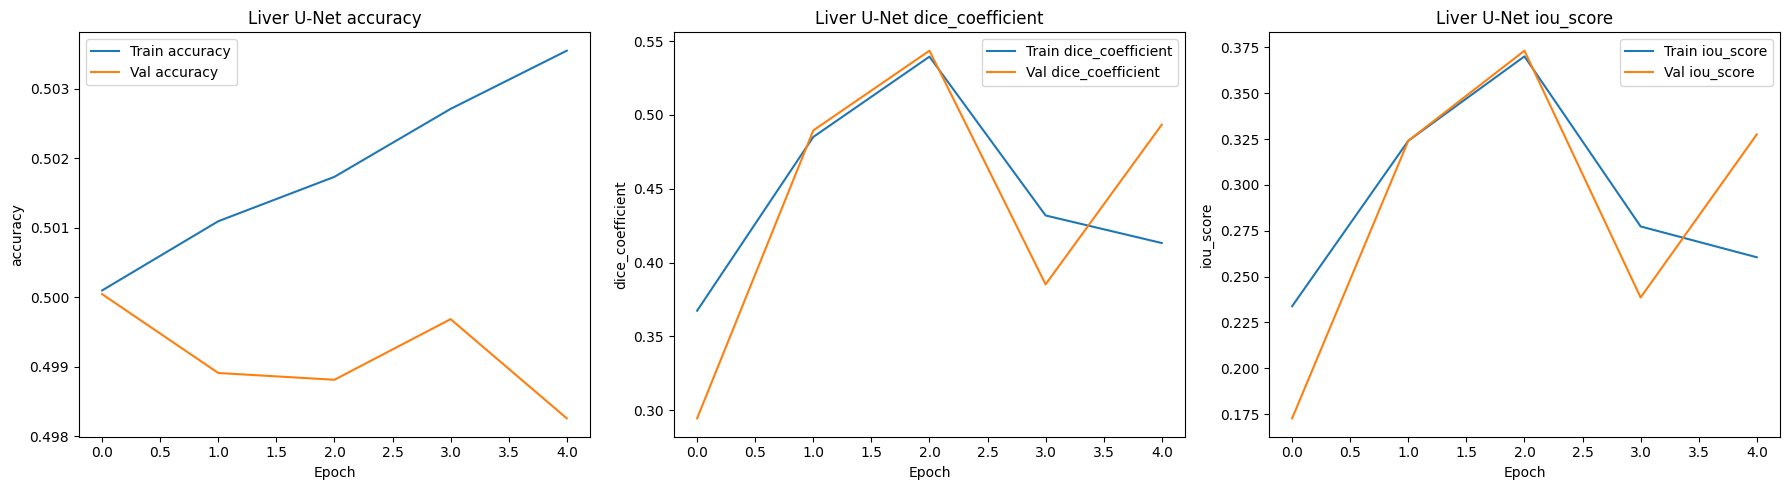


Training History Metrics for Liver SegNet:


,accuracy,dice_coefficient,iou_score,loss,val_accuracy,val_dice_coefficient,val_iou_score,val_loss
0,0.500096,0.367405,0.233852,0.693243,0.500043,0.294488,0.172686,0.693195
1,0.501093,0.485101,0.324059,0.693159,0.498907,0.489519,0.324091,0.693159
2,0.501732,0.539492,0.370099,0.693137,0.498810,0.543514,0.373182,0.693166
3,0.502710,0.431907,0.277348,0.693123,0.499683,0.385245,0.238590,0.693178
4,0.503548,0.413242,0.260529,0.693099,0.498254,0.493413,0.327515,0.693185


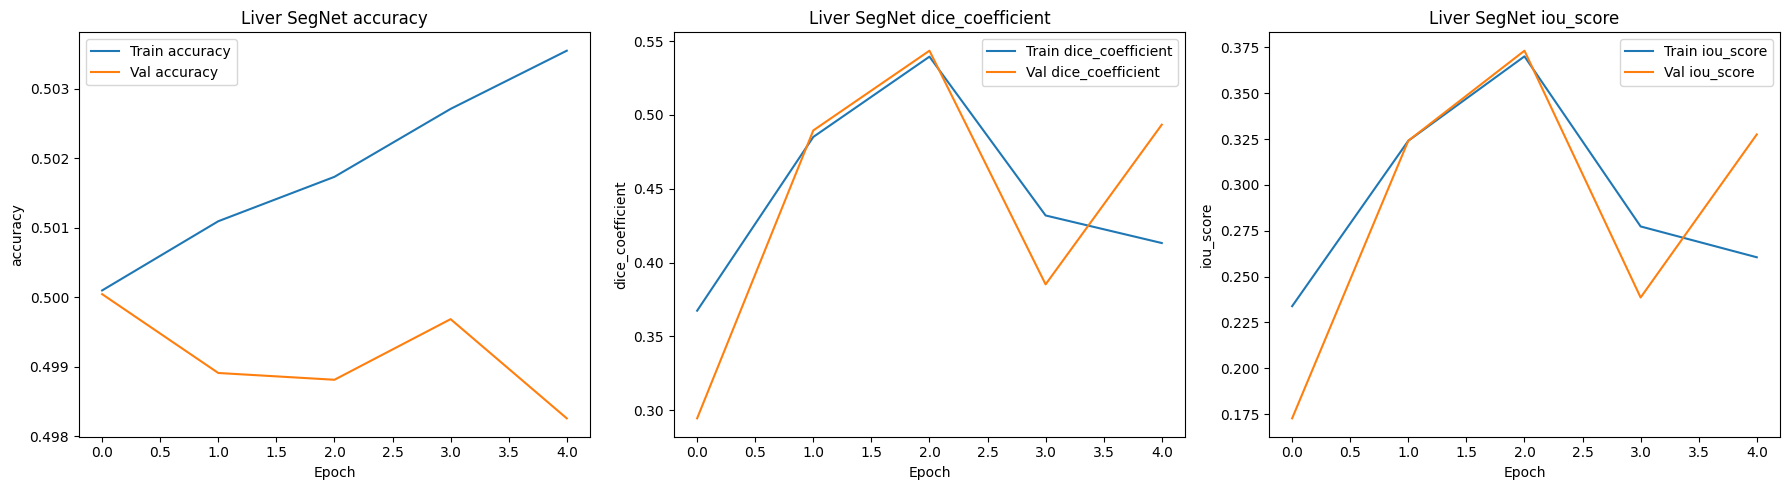

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np

# ========================
# 1️⃣ Example Dataset
# ========================
def load_dataset(name):
    X = np.random.rand(50, 128, 128, 3)
    y = np.random.randint(0, 2, size=(50, 128, 128, 1))
    return X, y

X, y = load_dataset("liver")  # or "lungs"
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 2️⃣ Dice and IoU metrics
# ========================
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.argmax(y_pred, axis=-1), [-1])
    intersection = tf.reduce_sum(tf.cast(y_true_f * y_pred_f, tf.float32))
    return (2. * intersection + smooth) / (tf.reduce_sum(tf.cast(y_true_f, tf.float32)) + tf.reduce_sum(tf.cast(y_pred_f, tf.float32)) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.argmax(y_pred, axis=-1), [-1])
    intersection = tf.reduce_sum(tf.cast(y_true_f * y_pred_f, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true_f, tf.float32)) + tf.reduce_sum(tf.cast(y_pred_f, tf.float32)) - intersection
    return (intersection + smooth) / (union + smooth)

# ========================
# 3️⃣ Simple U-Net / SegNet models
# ========================
def simple_unet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D()(c2)

    u1 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(p2)
    u2 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(u1)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(u2)

    return models.Model(inputs, outputs)

# ========================
# 4️⃣ Compile model
# ========================
model = simple_unet(input_size=X_train.shape[1:], num_classes=2)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', dice_coefficient, iou_score]
)
model.summary()

# ========================
# 5️⃣ Train model
# ========================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4
)

# ========================
# 6️⃣ Plot training history (3 metrics)
# ========================
def plot_training_history_3metrics(history, model_name="Model"):
    history_df = pd.DataFrame(history.history)
    print(f"\nTraining History Metrics for {model_name}:")
    display(history_df)

    plt.figure(figsize=(18,5))
    metrics = ['accuracy', 'dice_coefficient', 'iou_score']

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(1,3,i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{model_name} {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history_3metrics(history, model_name="Liver U-Net")
plot_training_history_3metrics(history, model_name="Liver SegNet")
